In [180]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [181]:
! pip install ultralytics

In [182]:
import torch
import torch.nn as nn
from ultralytics import YOLO
from torchvision import transforms
from PIL import Image
import numpy as np

In [283]:



# Step 1: Load trained YOLOv8 model
model = YOLO('/content/drive/MyDrive/DM project/best.pt')
image_path = '/content/drive/MyDrive/DM project/stop.png'

# Step 2: Extract the backbone (CSPDarknet53)
backbone = model.model.model[:10]
labels = torch.tensor([1])

num_classes = 29
sample_image = torch.randn(1, 3, 416, 416)  # Adjust size if necessary
sample_output = backbone(sample_image)
output_channels = sample_output.shape[1]
classify_model = nn.Sequential(
    backbone,  # Use the CSPDarknet53 backbone
    nn.AdaptiveAvgPool2d((1, 1)),  # Global Average Pooling to reduce to (batch_size, channels, 1, 1)
    nn.Flatten(),  # Flatten to (batch_size, channels)
    nn.Linear(in_features=output_channels, out_features=num_classes)  # Linear layer for classification
)

preprocess = transforms.Compose([
    transforms.Resize((416, 416)),  # Resize to 416x416
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

#STEP 1
image = Image.open(image_path).convert("RGB")
image = preprocess(image).unsqueeze(0)

# transformations
transformations = transforms.Compose([
    transforms.RandomRotation(degrees=(-10, 10)),
    transforms.RandomResizedCrop(size=image.shape[2:], scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2)
])
#  FGSM attack function
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

def get_yolo_output(model, image):
    results = model(image)
    return results[0].boxes.xyxy, results[0].boxes.conf, results[0].boxes.cls



In [284]:
# Step 4: EOT training loop
num_iterations = 100         #!!!!!try iterations=50 and epsilon=0.03 for no detection
epsilon = 0.01
image_unchanged=image
image_unchanged = torch.clamp(image_unchanged, 0, 1)
for iteration in range(num_iterations):
    image.requires_grad = True

    transformed_image = transformations(image.squeeze(0))
    transformed_image = transformed_image.unsqueeze(0)
    outputs = classify_model(transformed_image)

    classify_model.zero_grad()
    loss = nn.functional.cross_entropy(outputs, labels)
    loss.backward()

    data_grad = image.grad.data

    perturbed_image = fgsm_attack(transformed_image, epsilon, data_grad)
    pred=classify_model(perturbed_image)
    _, predicted_classes = torch.max(pred, 1)  # Extract predicted classes
    #print(f"The predicted class is {predicted_classes}")
    if labels.item() == predicted_classes.item():
        print("YES")
        epsilon = -abs(epsilon)  # Set epsilon to negative if target class is predicted
    else:
        epsilon = abs(epsilon)

    delta = perturbed_image - image
    delta = torch.clamp(delta, -epsilon, epsilon)
    image = (image + delta).detach()
     # Printing for monitoring loss
    if iteration % 20 == 0:
        print(f'Iteration {iteration}, Loss: {loss.item()}')



Iteration 0, Loss: 3.2615294456481934
Iteration 20, Loss: 3.2499547004699707
Iteration 40, Loss: 3.2291526794433594
Iteration 60, Loss: 3.266580104827881
Iteration 80, Loss: 3.285372734069824


In [285]:
# Saving image

final_image = image.squeeze().permute(1, 2, 0).numpy()
final_image_2 = (final_image * 255).astype(np.uint8)
Image.fromarray(final_image_2).save('perturbed_image.jpg')

In [286]:

boxes, scores, labels = get_yolo_output(model, image_unchanged)
perturbed_boxes, perturbed_scores, perturbed_labels = get_yolo_output(model, final_image)


0: 416x416 1 Stop_Sign, 388.5ms
Speed: 0.1ms preprocess, 388.5ms inference, 4.6ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 1 Turn right ahead, 401.9ms
Speed: 4.4ms preprocess, 401.9ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)


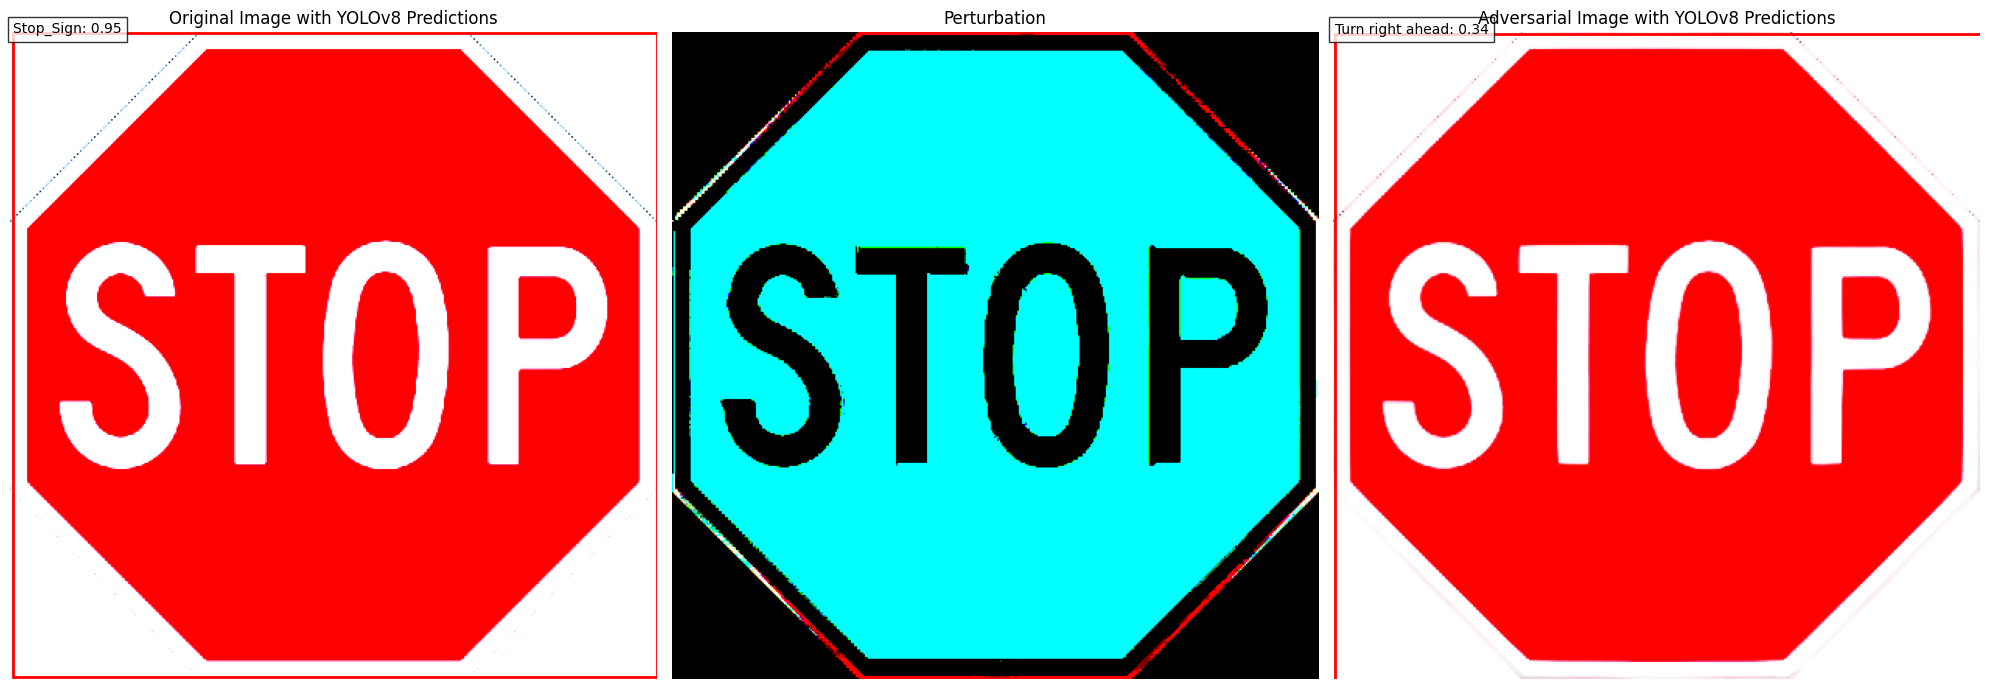

In [287]:
import matplotlib.pyplot as plt

def plot_boxes(ax, boxes, scores, labels, title, image_tensor):
    ax.imshow(image_tensor.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = box.detach().cpu().numpy()
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='r', linewidth=2)
        ax.add_patch(rect)
        ax.text(x1, y1, f"{model.names[int(label)]}: {score:.2f}", bbox=dict(facecolor='white', alpha=0.8))
    ax.set_title(title)
    ax.axis('off')

fig, axs = plt.subplots(1, 3, figsize=(20, 10))

# Original image with predictions
plot_boxes(axs[0], boxes, scores, labels, "Original Image with YOLOv8 Predictions", image_unchanged)
# Perturbation
perturbation = (delta).squeeze().permute(1, 2, 0).cpu().detach().numpy()
perturbation = (perturbation - perturbation.min()) / (perturbation.max() - perturbation.min())
axs[1].imshow(perturbation)
axs[1].set_title("Perturbation")
axs[1].axis('off')
image=torch.clamp(image, 0, 1)
# Adversarial image with predictions
plot_boxes(axs[2], perturbed_boxes, perturbed_scores, perturbed_labels, "Adversarial Image with YOLOv8 Predictions", image)

plt.tight_layout()
plt.show()


In [ ]:

model.names

{0: '-Road narrows on right',
 1: '50 mph speed limit',
 2: 'Attention Please-',
 3: 'Beware of children',
 4: 'CYCLE ROUTE AHEAD WARNING',
 5: 'Dangerous Left Curve Ahead',
 6: 'Dangerous Rright Curve Ahead',
 7: 'End of all speed and passing limits',
 8: 'Give Way',
 9: 'Go Straight or Turn Right',
 10: 'Go straight or turn left',
 11: 'Keep-Left',
 12: 'Keep-Right',
 13: 'Left Zig Zag Traffic',
 14: 'No Entry',
 15: 'No_Over_Taking',
 16: 'Overtaking by trucks is prohibited',
 17: 'Pedestrian Crossing',
 18: 'Round-About',
 19: 'Slippery Road Ahead',
 20: 'Speed Limit 20 KMPh',
 21: 'Speed Limit 30 KMPh',
 22: 'Stop_Sign',
 23: 'Straight Ahead Only',
 24: 'Traffic_signal',
 25: 'Truck traffic is prohibited',
 26: 'Turn left ahead',
 27: 'Turn right ahead',
 28: 'Uneven Road'}